**Using the model trained by *CNN_train_with_metadata* I fine tuned it on available training data(dataset1 + dataset2) for classification without metadata in this notebook**

Importing all necessary libraries

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.amp import autocast, GradScaler
import time
import copy

Checking if CUDA is available

In [38]:
print(f'torch version = {torch.__version__}')
#checking if CUDA is available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

torch version = 2.5.0+cu118
device = cuda


Setting seed for reproducability

In [39]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Defining Hyperparameters

In [40]:
IMG_SIZE = 224  #Majority of the images are of size 480x640 but some are of size 640x480
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10  # 9 diseases + normal
LEARNING_RATE = 0.001

Defining training path

In [41]:
DATASET_PATH = '.'
TRAIN_PATH = os.path.join(DATASET_PATH, 'more_train_images')

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Created dataset

In [42]:
train_dataset = ImageFolder(TRAIN_PATH, transform=train_transforms)
print(len(train_dataset))

16509


Defined a function to split training data

In [43]:
# Create subset datasets
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

Created train and validation sets and their respective DataLoaders

In [44]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Custom random split
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]


train_subset = SubsetDataset(train_dataset, train_indices)
val_subset = SubsetDataset(train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
class_names = train_dataset.classes

In [45]:
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [46]:
print(f"Classes: {class_names} \n")
print(f"Number of training samples: {len(train_subset)} \n")
print(f"Number of validation samples: {len(val_subset)}")

Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'] 

Number of training samples: 13207 

Number of validation samples: 3302


Defined model for classifiaction without metadata, uses the pretrained model with metadata without the matadata part

In [47]:
# Modified CNN model that incorporates metadata
class MetadataAwareModel(nn.Module):
    def __init__(self, base_model_name='resnet50', num_classes=10, num_varieties=1):
        super(MetadataAwareModel, self).__init__()

        # Initialize the CNN backbone
        if base_model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # Remove the final fully connected layer

        elif base_model_name == 'efficientnet':
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()  # Remove the final classifier

        elif base_model_name == 'densenet':
            self.backbone = models.densenet121(pretrained=True)
            self.feature_dim = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()  # Remove the final classifier

        # Layers for processing metadata
        self.variety_fc = nn.Linear(num_varieties, 64)
        self.age_fc = nn.Linear(1, 16)

        # Combined feature dimension
        combined_dim = self.feature_dim + 64 + 16

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, variety, age):
        # Process image through the backbone
        image_features = self.backbone(image)

        # Process metadata
        variety_features = torch.relu(self.variety_fc(variety))
        age_features = torch.relu(self.age_fc(age))

        # Concatenate all features
        combined_features = torch.cat([image_features, variety_features, age_features], dim=1)

        # Final classification
        output = self.classifier(combined_features)

        return output
    

class ImageOnlyModel(nn.Module):
    def __init__(self, pretrained_model_path, base_model_name='densenet', num_classes=10):
        super(ImageOnlyModel, self).__init__()

        # Load the pre-trained model
        pretrained_model = MetadataAwareModel(base_model_name=base_model_name, num_classes=num_classes, num_varieties=10)
        pretrained_model.load_state_dict(torch.load(pretrained_model_path, map_location=device,weights_only=True))
        
        # Extract the CNN backbone from the pre-trained model
        self.backbone = pretrained_model.backbone  # Keeping the pretrained feature extractor
        self.feature_dim = pretrained_model.feature_dim  # Feature size from CNN

        # New classifier (without metadata features)
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image):
        # Extract image features
        image_features = self.backbone(image)

        # Pass through new classifier
        output = self.classifier(image_features)

        return output

Defined my training function

In [48]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    scaler = GradScaler()  # Enable AMP (Mixed Precision Training)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'In phase {phase}')
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            print(f'Starting iteration over data')
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                  with autocast(device_type=str(device)):  # Mixed Precision Training
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        # loss.backward()
                        # optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Defined my evaluation function

In [49]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    labels = list(range(len(train_dataset.classes)))
    report = classification_report(all_labels, all_preds,labels=labels, target_names=train_dataset.classes, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=labels)

    return report, conf_matrix, all_preds, all_labels

Defined a function for plotting

In [50]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('CNN_training_history_without_metadata.png')
    plt.show()


Defined a function to plot confusion matrix

In [51]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('CNN_confusion_matrix_without_metadata.png')
    plt.show()

Training my model

In [52]:
torch.cuda.empty_cache()
model_name = 'densenet'
model=ImageOnlyModel('paddy_disease_densenet_with_metadata.pth',base_model_name=model_name,num_classes=10)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)

# Save the model
torch.save(model.state_dict(), f'paddy_disease_{model_name}_without_metadata.pth')

Epoch 1/10
----------
In phase train
Starting iteration over data
train Loss: 1.0618 Acc: 0.6017
In phase val
Starting iteration over data
val Loss: 0.8014 Acc: 0.6760

Epoch 2/10
----------
In phase train
Starting iteration over data
train Loss: 0.8410 Acc: 0.6759
In phase val
Starting iteration over data
val Loss: 0.7618 Acc: 0.6941

Epoch 3/10
----------
In phase train
Starting iteration over data
train Loss: 0.7373 Acc: 0.7130
In phase val
Starting iteration over data
val Loss: 0.6751 Acc: 0.7220

Epoch 4/10
----------
In phase train
Starting iteration over data
train Loss: 0.5301 Acc: 0.7730
In phase val
Starting iteration over data
val Loss: 0.4151 Acc: 0.8098

Epoch 5/10
----------
In phase train
Starting iteration over data
train Loss: 0.4721 Acc: 0.7937
In phase val
Starting iteration over data
val Loss: 0.3974 Acc: 0.8204

Epoch 6/10
----------
In phase train
Starting iteration over data
train Loss: 0.4460 Acc: 0.8007
In phase val
Starting iteration over data
val Loss: 0.3799

Evaluation report


Test Results:
Accuracy: 0.8301

Classification Report:
bacterial_leaf_blight: Precision: 0.9691, Recall: 0.9171, F1-Score: 0.9424
bacterial_leaf_streak: Precision: 0.8507, Recall: 0.8636, F1-Score: 0.8571
bacterial_panicle_blight: Precision: 0.8841, Recall: 0.9242, F1-Score: 0.9037
blast: Precision: 0.7647, Recall: 0.5549, F1-Score: 0.6431
brown_spot: Precision: 0.6153, Recall: 0.8192, F1-Score: 0.7027
dead_heart: Precision: 0.9571, Recall: 0.9606, F1-Score: 0.9589
downy_mildew: Precision: 0.8235, Recall: 0.7313, F1-Score: 0.7747
hispa: Precision: 0.8684, Recall: 0.8967, F1-Score: 0.8824
normal: Precision: 0.9088, Recall: 0.9592, F1-Score: 0.9333
tungro: Precision: 0.9317, Recall: 0.9421, F1-Score: 0.9369


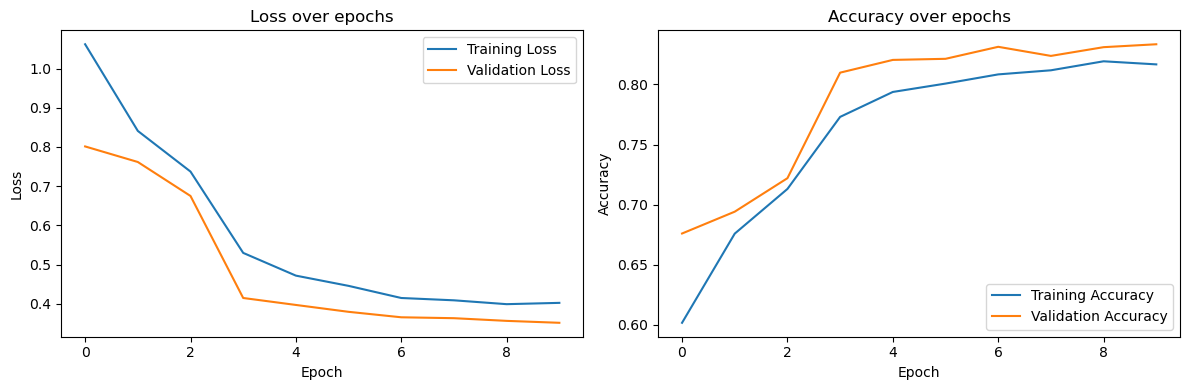

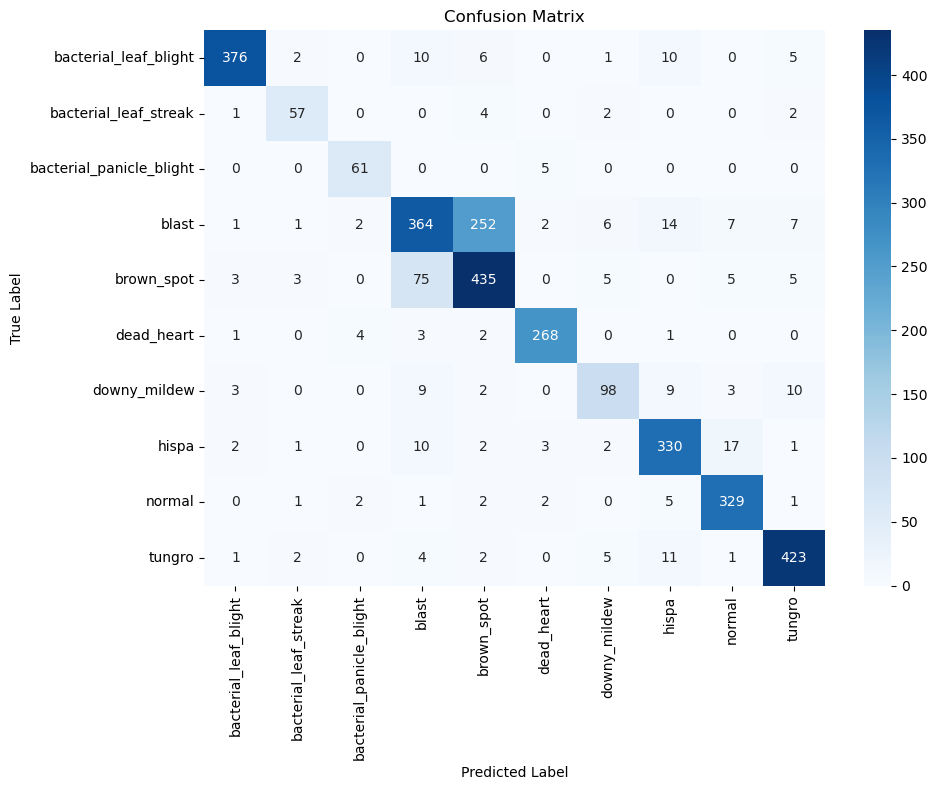

In [53]:
test_report, test_conf_matrix, test_preds, test_labels = evaluate_model(model, val_loader)

# Print test results
print("\nTest Results:")
print(f"Accuracy: {test_report['accuracy']:.4f}")
print("\nClassification Report:")
for class_name in train_dataset.classes:
    print(f"{class_name}: Precision: {test_report[class_name]['precision']:.4f}, "
            f"Recall: {test_report[class_name]['recall']:.4f}, "
            f"F1-Score: {test_report[class_name]['f1-score']:.4f}")

# Plot results
plot_training_history(history)
plot_confusion_matrix(test_conf_matrix, train_dataset.classes)